# Session 5: Coding Solution

```{contents}

```

## The mechanism of Dropout Layer

```python
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Input(...))
model.add(Dense(...)) # no activation
model.add(Dropout(0.2))
model.add(Activation(...))
```

In the above exmaple, we create an layer `dropout_rate = 0.2`.

That is, `each unit` in the Dense layer will have a 20% probability of being assigned to the value = 0.

The remaining numbers will be scaled up according to the formula

$$
\text{new value} = \text{old value} * \frac{1}{1-\text{rate}}
$$

Let's go through the detailed example below to better understand

In [ ]:
from tensorflow.random import set_seed
from tensorflow.keras.layers import Dropout

layer = Dropout(0.2, input_shape=(2,))

Create a matrix with shape = $(5,2)$ representing the Dense layer

In [ ]:
import numpy as np

np.random.seed(42)

data = np.arange(10).reshape(5, 2).astype(np.float32)
print(data)

[[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]
 [8. 9.]]


Pass the above matrix through the Dropout layer

In [ ]:
set_seed(42)

outputs = layer(data, training=True)
print(outputs)

tf.Tensor(
[[ 0.    1.25]
 [ 2.5   3.75]
 [ 0.    6.25]
 [ 7.5   8.75]
 [10.   11.25]], shape=(5, 2), dtype=float32)


## A simple Spam Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare the dataset

In this article, we will practice using the `MLP` model to classify phone messages (SMS) as spam or normal messages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML-intensive/data/spam.csv', encoding='latin-1', usecols=[0,1],names=['Label','SMS'], header=0)
df.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Annotate the values in column **Label**
- **ham** means normal message
- **spam** means spam messages (ads, phishing, etc.)



#### TODO 1
- Print out **5 spam messages** and **5 ham messages**

In [ ]:
# YOUR SOLUTION
spam = df[df.Label == 'spam']
spam[:5]

,Label,SMS
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [ ]:
ham = df[df.Label == 'ham']
ham[:5]

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


We count the number of messages belonging to each **Label** to see if this data set is **Balanced Dataset** or **Imbalanced Dataset**

In [ ]:
df['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

We take the data in the SMS column as input **x**

Then convert **Label** into number
- **Ham** = 0
- **Spam** = 1

In [ ]:
# retrieve the data from the SMS column, then convert into numpy array
x = df['SMS'].values
# retrieve the data of the Label column
# binary mapping and convert into numpy array
y = df['Label'].map({'ham':0,'spam':1}).values

In [ ]:
x.shape, y.shape

((5572,), (5572,))

In [ ]:
y

array([0, 0, 1, ..., 0, 0, 0])

### Data Conversion

Remember that AI models take in data in the form of numbers. Therefore we will transform our data set from string of characters to numbers.

There are many ways to transform, here we will use the simplest method called **Count Vectorizer**. For example, we have a data set of 4 sentences as follows:

In [ ]:
example_data = [
  'This is the first document.',
  'This document is the second document.',
  'And this is the third one.',
  'Is this the first document?',
]

Perform **CountVectorizer** on `example_data`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # Import sklearn library

transformer = CountVectorizer()  # Initiallize CountVectorizer
transformer.fit(example_data) # Fit CountVectorizer on  example_data

example_features = transformer.transform(example_data).toarray() # create a set of features
print(example_features)

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


To understand the meaning of the numbers in variable 'example_features' one must understand how the **Count Vectorizer** transformation works

How the **Count Vectorizer** transformation works
- Step 1: Separate the dataset into a list of separate words (dictionary)

In [ ]:
# We can see the result of step 1 by the following function
print(transformer.get_feature_names_out())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


We see that from `example_dataset`, we can separate them into **9 seperable words**. `example_dataset` có 4 sentences

$\rightarrow$ `example_features` will have the shape of ``(4, 9)``


In [ ]:
print('Shape:',example_features.shape)

Shape: (4, 9)


- Step 2: Reconcile original data with separate words after splitting. These are the features of each sentence in the dataset. Example:
  - Sentence 1: `'This is the first document.'`. At the corresponding places there will be the number `n` meaning that the word appears `n` times in the sentence.
  ```
  ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
  [0 1 1 1 0 0 1 0 1]
  ```
  - Sentence 2: `'This document is the second document.'` There are 2 words in this sentence **document** $\rightarrow$ at the position [1] is 2
  ```
  ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
  [0 2 0 1 0 1 1 0 1]
  ```

We will apply **Count Vectorizer** to the SMS dataset

In [ ]:
# fit on x_train
transformer = CountVectorizer(stop_words = 'english').fit(x)
# transform on x_train and x_test
x_vectors = transformer.transform(x)

print('Shape of x_train:',x_vectors.shape)

Shape of x_train: (5572, 8404)


That is, in the dataset there are
- 5572 messages
- 8404 distinct words, each sample in the dataset is represented by a characteristic 8404

Also, when initializing `CountVectorizer`, we pass param `stop_words="english"`

In language processing, the term `stop_words` refers to words that are frequently used in a language, but do not make much sense. These words will be ignored when the `CountVectorizer` builds a dictionary of words. Run the cell below to see a list of `stop_words` in English



In [ ]:
transformer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [ ]:
len(transformer.get_stop_words())

318

You can completely create 1 `list` containing your own word stops and pass on to the `CountVectorizer` if you are not satisfied with the available `list`

### Train Test Split

#### TODO 2
Divide the dataset into Train and Test sets with:
- Test set size is 20% of the total data
- Use `stratified split`
-Shuffle
- Use random_state=42

In [ ]:
# YOUR SOLUTION
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_vectors, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4457, 8404), (1115, 8404), (4457,), (1115,))

### Train the model

#### TODO 3

Apply the MLP model to classify the above dataset. Once you're satisfied with the training results, draw a Confusion Matrix and print out a `classification_repor`.

Comment on the predicted results of the model based on the Confusion Matrix and Classification Report

In [ ]:
# YOUR SOLUTION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session

clear_session()
set_seed(42)
np.random.seed(42)

model = Sequential()
model.add(Input(shape=(x_train.shape[1:])))
model.add(Dense(32, activation='relu', name='layer_1'))
model.add(Dense(64, activation='relu', name='layer_2'))
model.add(Dense(128, activation='relu', name='layer_3'))
model.add(Dense(64, activation='relu', name='layer_4'))
model.add(Dense(32, activation='relu', name='layer_5'))
model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 32)                268960    
                                                                 
 layer_2 (Dense)             (None, 64)                2112      
                                                                 
 layer_3 (Dense)             (None, 128)               8320      
                                                                 
 layer_4 (Dense)             (None, 64)                8256      
                                                                 
 layer_5 (Dense)             (None, 32)                2080      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 289,761
Trainable params: 289,761
Non-trai

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")
history = model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
140/140 [==============================] - 3s 9ms/step - loss: 0.2281 - accuracy: 0.9264
Epoch 2/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0146 - accuracy: 0.9960
Epoch 3/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.9996
Epoch 4/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 5/10
140/140 [==============================] - 1s 6ms/step - loss: 3.3540e-04 - accuracy: 0.9998
Epoch 6/10
140/140 [==============================] - 1s 6ms/step - loss: 9.4479e-05 - accuracy: 1.0000
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 5.5155e-05 - accuracy: 1.0000
Epoch 8/10
140/140 [==============================] - 1s 9ms/step - loss: 3.7994e-05 - accuracy: 1.0000
Epoch 9/10
140/140 [==============================] - 1s 8ms/step - loss: 2.7231e-05 - accuracy: 1.0000
Epoch 10/10
140/140 [==============================] - 1s 6ms/step - loss: 2.0

In [ ]:
model.evaluate(x_test, y_test)

35/35 [==============================] - 1s 3ms/step - loss: 0.1397 - accuracy: 0.9857


[0.13970947265625, 0.9856502413749695]

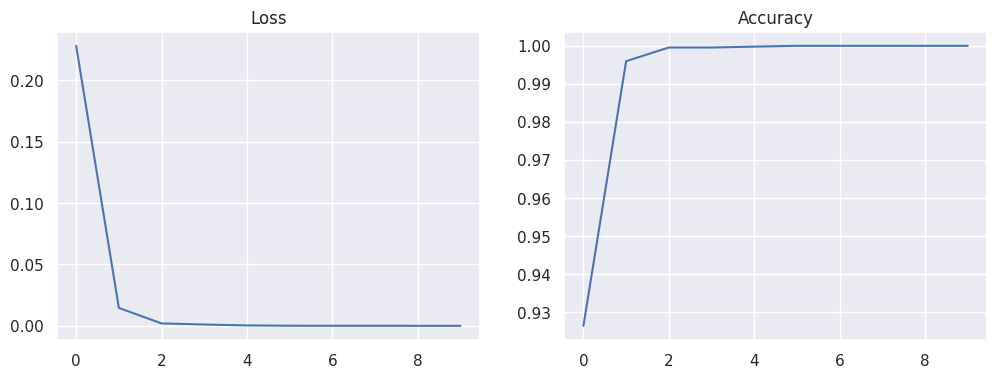

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'])

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.show()

There is no phenomonen of overfitting

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_pred = model.predict(x_test)
y_test_pred = [1 if y > 0.5 else 0 for y in y_test_pred]
len(y_test_pred)

35/35 [==============================] - 0s 2ms/step


1115

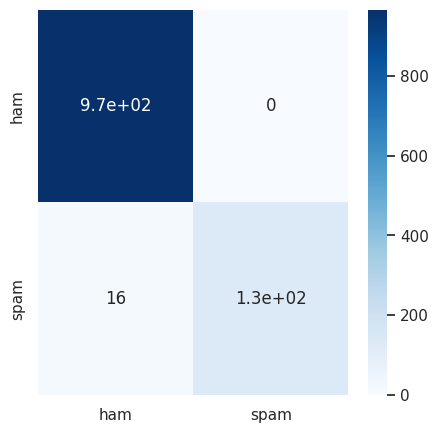

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['ham', 'spam',]
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.89      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



#### Your comment

High accuracy:

Spam: positive
- True Positive: 1.3e+02
- False Positive: 0
- True Negative: 9.7e+02
- False Negative: 16

$\rightarrow$ There are about 16 that are spam but predictably spam.